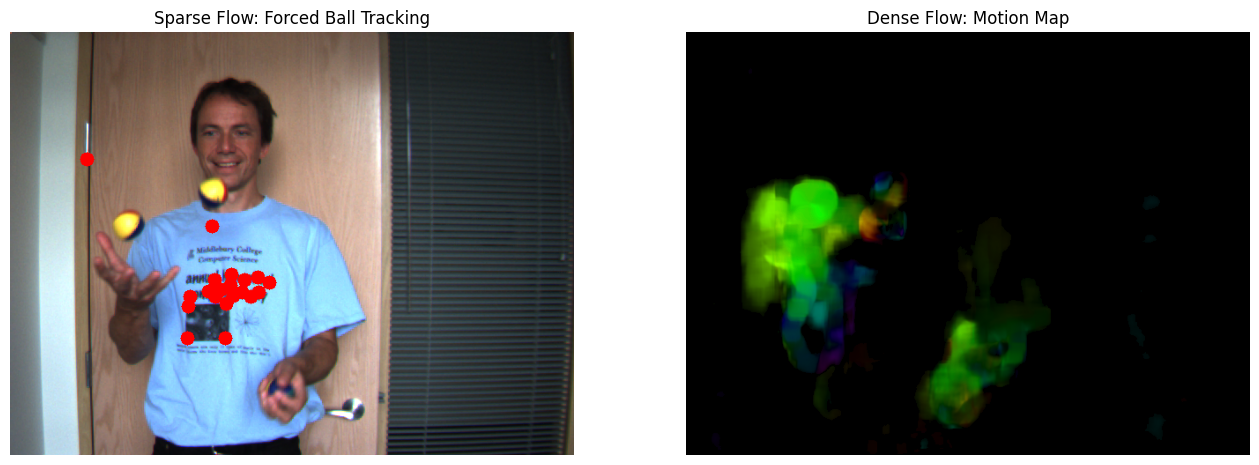

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# 1. Load your local images
path1 = "/content/frame10.png"
path2 = "/content/frame11.png"

img1 = cv2.imread(path1)
img2 = cv2.imread(path2)

if img1 is None or img2 is None:
    print("Error: Images not found.")
else:
    gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # --- PART 1: TARGETED SPARSE FLOW ---
    # Create a mask: Black everywhere, White where the balls are
    mask_roi = np.zeros_like(gray1)
    # We focus on the middle-left area where the balls are juggling
    # Coordinates [y1:y2, x1:x2] - adjusted for the juggling frame
    mask_roi[100:400, 50:400] = 255

    # Lower qualityLevel to 0.1 to be less 'picky' about the ball edges
    feature_params = dict(maxCorners=20, qualityLevel=0.1, minDistance=10, blockSize=7)
    lk_params = dict(winSize=(30, 30), maxLevel=2,
                    criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # We pass the mask_roi here so it ONLY looks for dots in that white box
    p0 = cv2.goodFeaturesToTrack(gray1, mask=mask_roi, **feature_params)

    p1, st, err = cv2.calcOpticalFlowPyrLK(gray1, gray2, p0, None, **lk_params)

    sparse_res = img2.copy()
    if p1 is not None:
        good_new = p1[st == 1]
        good_old = p0[st == 1]
        for i, (new, old) in enumerate(zip(good_new, good_old)):
            a, b = new.ravel().astype(int)
            c, d = old.ravel().astype(int)
            # Draw movement lines and dots
            cv2.line(sparse_res, (a, b), (c, d), (0, 255, 0), 2)
            cv2.circle(sparse_res, (a, b), 8, (0, 0, 255), -1)

    # --- PART 2: DENSE FLOW (Noise Filtered) ---
    flow = cv2.calcOpticalFlowFarneback(gray1, gray2, None, 0.5, 3, 15, 3, 5, 1.2, 0)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    mag[mag < 1.5] = 0 # Clean background

    hsv = np.zeros_like(img1)
    hsv[..., 1] = 255
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX)
    dense_res = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)

    # --- PART 3: VISUALIZATION ---
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(sparse_res, cv2.COLOR_BGR2RGB))
    plt.title('Sparse Flow: Forced Ball Tracking')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(dense_res, cv2.COLOR_BGR2RGB))
    plt.title('Dense Flow: Motion Map')
    plt.axis('off')
    plt.show()